In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do domínio e do fluido
Nx, Ny = 100, 100          # Número de células em x e y
Lx, Ly = 2.0, 2.0          # Dimensões do domínio (metros)
R = 0.1                    # Raio do cilindro (metros)
rho = 1.0                  # Densidade do fluido (kg/m³)
nu = 0.01                  # Viscosidade cinemática (m²/s)
U_entrada = 1.0            # Velocidade de entrada (m/s)
dt = 0.001                 # Passo temporal (s)

# Criação da malha
dx = Lx / Nx               # Tamanho da célula em x
dy = Ly / Ny               # Tamanho da célula em y
x = np.linspace(0, Lx, Nx) # Coordenadas x
y = np.linspace(0, Ly, Ny) # Coordenadas y

# Matrizes de velocidade e pressão iniciais
u = np.zeros((Nx, Ny))     # Velocidade na direção x
v = np.zeros((Nx, Ny))     # Velocidade na direção y
p = np.zeros((Nx, Ny))     # Pressão

# Definição do cilindro como uma região onde (x - xc)^2 + (y - yc)^2 < R^2
xc, yc = Lx/4, Ly / 2
for i in range(Nx):
    for j in range(Ny):
        if (x[i] - xc)**2 + (y[j] - yc)**2 < R**2:
            u[i, j] = 0
            v[i, j] = 0


In [81]:
# Condições de contorno
u[:, 0] = U_entrada       # Velocidade de entrada à esquerda
u[0, :] = 0               # Paredes superior e inferior do domínio
u[-1, :] = 0
v[:, 0] = 0
v[:, -1] = 0


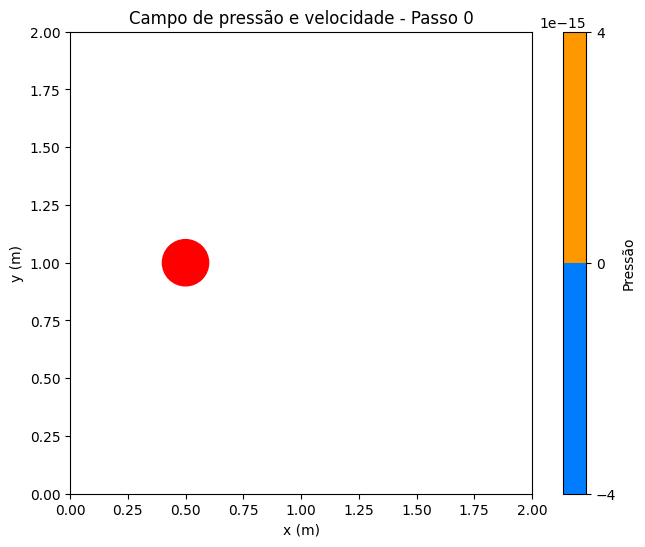

KeyboardInterrupt: 

In [87]:
# Parâmetros numéricos adicionais
num_steps = 500           # Número de passos de tempo
u_temp = np.copy(u)       # Matrizes temporárias para atualizar u e v
v_temp = np.copy(v)

# Loop temporal
for step in range(num_steps):
    # Termo convectivo (diferença finita "upwind")
    u_conv = u[1:-1, 1:-1] * (u[1:-1, 1:-1] - u[:-2, 1:-1]) / dx + \
             v[1:-1, 1:-1] * (u[1:-1, 1:-1] - u[1:-1, :-2]) / dy

    v_conv = u[1:-1, 1:-1] * (v[1:-1, 1:-1] - v[:-2, 1:-1]) / dx + \
             v[1:-1, 1:-1] * (v[1:-1, 1:-1] - v[1:-1, :-2]) / dy

    # Termo difusivo (diferença central)
    u_diff = nu * ((u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2 +
                   (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2)

    v_diff = nu * ((v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[:-2, 1:-1]) / dx**2 +
                   (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, :-2]) / dy**2)

    # Atualização das velocidades temporárias
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt * (-u_conv + u_diff)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt * (-v_conv + v_diff)

    # Aplicação das condições de contorno (não deslizamento no cilindro e bordas)
    u_temp[:, 0] = U_entrada   # Velocidade de entrada à esquerda
    u_temp[0, :] = 0           # Paredes superior e inferior
    u_temp[-1, :] = 0
    u_temp[:, -1] = u_temp[:, -2]  # Condição de saída com gradiente zero
    v_temp[:, 0] = 0
    v_temp[:, -1] = v_temp[:, -2]

    # Atualização das velocidades
    u = np.copy(u_temp)
    v = np.copy(v_temp)

    # Inicialização do campo de pressão
    p = np.zeros((Nx, Ny))

    # Atualização da pressão para cada passo
    # Resolver a equação de Poisson para a pressão
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            if (x[i] - xc)**2 + (y[j] - yc)**2 >= R**2:
                p[i, j] = 0.25 * (p[i+1, j] + p[i-1, j] + p[i, j+1] + p[i, j-1] -
                                  (rho * ((u[i+1, j] - u[i-1, j]) / (2*dx) +
                                          (v[i, j+1] - v[i, j-1]) / (2*dy))))

        # Aplicar condições de contorno de velocidade e pressão nas paredes do domínio
        p[:, 0] = p[:, 1]      # Condição de contorno na borda esquerda
        p[:, -1] = p[:, -2]    # Condição de contorno na borda direita
        p[0, :] = p[1, :]      # Condição de contorno na borda inferior
        p[-1, :] = p[-2, :]    # Condição de contorno na borda superior

        # Atualizar velocidades com o campo de pressão ajustado
        u[1:-1, 1:-1] -= dt * (p[2:, 1:-1] - p[:-2, 1:-1]) / (2 * dx)
        v[1:-1, 1:-1] -= dt * (p[1:-1, 2:] - p[1:-1, :-2]) / (2 * dy)

    # Aplicar a condição de não deslizamento ao redor do cilindro
    for i in range(Ny):
        for j in range(Nx):
            if (x[j] - xc)**2 + (y[i] - yc)**2 < R**2:
                u[j, i] = 0
                v[j, i] = 0

    # Visualização (opcional): Plota o campo de velocidade em intervalos
    # Visualização (opcional): Plota o campo de velocidade em intervalos
    if step % 50 == 0:
        plt.figure(figsize=(8, 6))
        plt.contourf(x, y, p.T, levels=50, cmap='jet')
        plt.colorbar(label="Pressão")
        plt.quiver(x, y, u.T, v.T, color='w')
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.title(f"Campo de pressão e velocidade - Passo {step}")
        plt.gca().add_artist(plt.Circle((xc, yc), R, color='r', fill=True))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros físicos e de malha
nx, ny = 100, 100    # número de pontos na malha
Lx, Ly = 4.0, 4.0  # dimensões do domínio em metros
dx, dy = Lx / (nx - 1), Ly / (ny - 1)  # espaçamento entre pontos
dt = 0.001         # passo de tempo
num_steps = 500    # número de passos de tempo
U_entrada = 0.5    # velocidade de entrada do fluido
rho = 1.0          # densidade do fluido
nu = 0.1           # viscosidade cinemática

# Parâmetros do cilindro
R = 0.25            # raio do cilindro
xc, yc = Lx /4 , Ly / 2  # posição do cilindro

# Criação das matrizes de velocidade e pressão
u = np.zeros((nx, ny))  # velocidade em x
v = np.zeros((nx, ny))  # velocidade em y
p = np.zeros((nx, ny))  # pressão

# Criação das coordenadas x e y
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Condição de entrada
v[:, 0] = U_entrada       # Velocidade constante na borda esquerda
#v[:, -1] = -U_entrada     # Velocidade de entrada pela direita

# Loop temporal
for step in range(num_steps):
    # Cópia das velocidades para preservar valores anteriores
    un = u.copy()
    vn = v.copy()

    # Termos convectivos e difusivos para atualizar u e v
    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[:-2, 1:-1]) -
                     vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[1:-1, :-2]) +
                     nu * dt / dx**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) +
                     nu * dt / dy**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) -
                     vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[1:-1, :-2]) +
                     nu * dt / dx**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) +
                     nu * dt / dy**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]))

    # Resolver a equação de Poisson para a pressão
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            if (x[i] - xc)**2 + (y[j] - yc)**2 >= R**2:
                p[i, j] = 0.25 * (p[i+1, j] + p[i-1, j] + p[i, j+1] + p[i, j-1] -
                                  (rho * ((u[i+1, j] - u[i-1, j]) / (2*dx) +
                                          (v[i, j+1] - v[i, j-1]) / (2*dy))))

    # Aplicar condições de contorno de pressão
    p[:, 0] = p[:, 1]      # Borda esquerda
    p[:, -1] = p[:, -2]    # Borda direita
    p[0, :] = p[1, :]      # Borda inferior
    p[-1, :] = p[-2, :]    # Borda superior

    # Atualizar velocidades com o campo de pressão
    u[1:-1, 1:-1] -= dt * (p[2:, 1:-1] - p[:-2, 1:-1]) / (2 * dx)
    v[1:-1, 1:-1] -= dt * (p[1:-1, 2:] - p[1:-1, :-2]) / (2 * dy)

    # Aplicar condição de não deslizamento ao redor do cilindro
    for i in range(ny):
        for j in range(nx):
            if (x[j] - xc)**2 + (y[i] - yc)**2 < R**2:
                u[j, i] = 0
                v[j, i] = 0

    # Visualização periódica do campo de pressão e velocidade
    if step % 50 == 0:
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, p.T, levels=50, cmap='seismic')
        plt.colorbar(label="Pressão")
        plt.quiver(X, Y, u.T, v.T, color='cyan')
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.title(f"Campo de pressão e velocidade - Passo {step}")
        plt.gca().add_artist(plt.Circle((xc, yc), R, color='black', fill=True))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.